# Heat conduction with PINN

## 1. Steady State Heat conduction with PINN

Consider the PDEs:

$$
0=\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2},
$$

with the initial conditions:
$$
T(x, y, 0) = T_i
$$

and the boundary conditions:

$$
\begin{aligned}
&T(x, 0, t) = T_b,\ &&T(x, L_y, t) = T_t\\
&-kT_x(0, y, t) = q_L,\ &&-kT_x(0, y, t) = q_R
\end{aligned}
$$

We write the trial solution by:
$$
\hat{T}(x,y,t;\theta)=\mathcal{N}(x, y, t;\theta)
$$

where $\mathcal{N}(x, y, t; \theta)$ is a neural network (NN).

Define residual $f$ as:

$$
f(x, y, t;\hat{T}(x, y, t))
$$

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
T_infty = 0.2
T_i = 0.
T_b = 0.
T_t = 1.
L_x = 1.0
L_y = 1.0
q_L = -0.5
q_R = 0.5

alpha = 1.0

BC_numbers = [400, 100, 400, 100]      # Order: right, left
n_BC_cum = [np.sum(BC_numbers[0:(i+1)]) for i in range(4)]
print(n_BC_cum)
GOV_number = 10

[400, 500, 900, 1000]


In [3]:
layer_nodes = 100

nn_heat = nn.Sequential( 
    nn.Linear(2, layer_nodes), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, layer_nodes, bias=True), nn.Sigmoid(), 
    nn.Linear(layer_nodes, 1, bias=False)
).to(device)

"""
nn_heat = nn.Sequential( 
    nn.Linear(2, 10), nn.Sigmoid(), 
    nn.Linear(10, 20, bias=True), nn.Sigmoid(), 
    nn.Linear(20, 40, bias=True), nn.Sigmoid(), 
    nn.Linear(40, 80, bias=True), nn.Sigmoid(), 
    nn.Linear(80, 40, bias=True), nn.Sigmoid(), 
    nn.Linear(40, 20, bias=True), nn.Sigmoid(), 
    nn.Linear(20, 10, bias=True), nn.Sigmoid(), 
    nn.Linear(10, 1, bias=False)
).to(device)
"""

"""
getTemperature = lambda X: (L_y - X[:, 1:2])*X[:, 1:2]*nn_heat(X) + \
    X[:, 1:2]*(T_t-T_b) + T_b
"""


# f = lambda lapT, Tt: torch.mean(1./alpha*Tt - lapT)     # Residual for the GOV

square_mean  = lambda ts: torch.mean(ts**2)

def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), 
        create_graph=True)[0]

def laplacian(field_value, X):
    gradV = grad(field_value, X)
    Vxx = grad(gradV[:, 0], X)[:, 0]
    Vyy = grad(gradV[:, 1], X)[:, 1]
    return Vxx+Vyy

# The loss function
def loss(X, i):
    X.requires_grad = True
    field_value = nn_heat(X)
    # print(field_value)
    # The laplacian of the field_value
    gradT = grad(field_value, X)
    lapT = laplacian(field_value, X)
    # res1 = torch.mean(lapT**2)
    res1 = square_mean(lapT)

    # Top BC:
    BC_value = field_value[0:n_BC_cum[0], :]
    # res2 = torch.mean(((BC_value-T_t))**2)
    res2 = square_mean(BC_value-T_t)

    # Right BC:
    BC_Tx = gradT[n_BC_cum[0]:n_BC_cum[1], 0]
    # res3 = torch.mean(((BC_Tx-q_L)/q_L)**2)
    res3 = square_mean((BC_Tx-q_L)/q_L)

    # Buttom BC:
    BC_value = field_value[n_BC_cum[1]:n_BC_cum[2], :]
    # res4 = torch.mean(((BC_value-T_b))**2)
    res4 = square_mean(BC_value-T_b)

    # Left BC:
    BC_Tx = gradT[n_BC_cum[2]:n_BC_cum[3], 0]
    # res5 = torch.mean(((BC_Tx-q_R)/q_R)**2)
    res5 = square_mean((BC_Tx-q_R)/q_R)
    
    if i%100==99:
        print(
            round(res1.item(), 3),
            round(res2.item(), 3),
            round(res3.item(), 3),
            round(res4.item(), 3),
            round(res5.item(), 3),
        )

    return res1+res2+res3+res4+res5


In [4]:
adam = torch.optim.Adam(nn_heat.parameters(), lr=1e-4)

to1 = lambda ts: torch.sin(ts*torch.pi/2)
to0 = lambda ts: -torch.sin(ts*torch.pi/2) + 1.0

n_batch = n_BC_cum[3] + GOV_number

max_it = 4000

for i in range(max_it):
    X = torch.rand(n_batch, 2).to(device)

    # Top
    X[0:n_BC_cum[0], 1] = 1.

    # Right
    X[n_BC_cum[0]:n_BC_cum[1], 0] = 1.
    
    # Buttom
    X[n_BC_cum[1]:n_BC_cum[2], 1] = 0.

    # Left
    X[n_BC_cum[2]:n_BC_cum[3], 0] = 0.

    adam.zero_grad()
    l = loss(X, i)
    l.backward()
    adam.step()
    if i%100==99:
        print(i+1, l)

0.0 0.248 0.999 0.251 1.0
100 tensor(2.4982, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.246 0.998 0.249 1.0
200 tensor(2.4937, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.237 0.994 0.245 1.001
300 tensor(2.4764, device='cuda:0', grad_fn=<AddBackward0>)
0.0 0.196 0.97 0.213 0.998
400 tensor(2.3776, device='cuda:0', grad_fn=<AddBackward0>)
0.045 0.051 0.898 0.055 0.896
500 tensor(1.9453, device='cuda:0', grad_fn=<AddBackward0>)
0.104 0.005 0.782 0.004 0.713
600 tensor(1.6090, device='cuda:0', grad_fn=<AddBackward0>)
0.127 0.0 0.566 0.001 0.486
700 tensor(1.1795, device='cuda:0', grad_fn=<AddBackward0>)
0.19 0.002 0.262 0.005 0.235
800 tensor(0.6936, device='cuda:0', grad_fn=<AddBackward0>)
0.153 0.003 0.124 0.007 0.103
900 tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)
0.055 0.004 0.054 0.003 0.043
1000 tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)
0.019 0.002 0.031 0.001 0.013
1100 tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)
0.016 0.002 0.027 0.001 

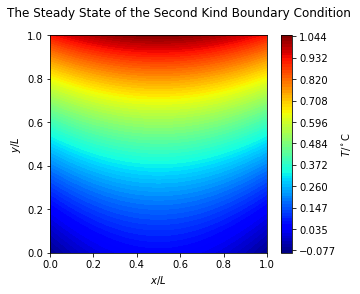

In [6]:
xt_plot = torch.linspace(0, 1, 100)
yt_plot = torch.linspace(0, 1, 100)
[xt_plot, yt_plot] = torch.meshgrid(xt_plot, yt_plot, indexing="ij")
X = torch.cat((xt_plot.reshape(-1)[:, None], yt_plot.reshape(-1)[:, None]), axis=1).to(device)
T = nn_heat(X)
xt_plot = X[:, 0].reshape(100, 100).cpu().detach().numpy()
yt_plot = X[:, 1].reshape(100, 100).cpu().detach().numpy()
T = T.reshape(100, 100).cpu().detach().numpy()

from matplotlib import cm
fig = plt.figure(figsize=(5, 4))
fig.suptitle("The Steady State of the Second Kind Boundary Condition")
ax = fig.add_subplot(111)
cs = ax.contourf(xt_plot, yt_plot, T, 100, cmap=cm.jet)
colorbar = fig.colorbar(cs)
colorbar.set_ticks(np.linspace(np.min(T), np.max(T), 11))
colorbar.set_label(r'$T/\mathrm{^\circ C}$')
"""
More information about colorbar can be found at the official documentation.
I've been bordered with this problem for a long time. It is very helpful!!!
https://matplotlib.org/3.5.0/api/colorbar_api.html#matplotlib.colorbar.Colorbar
"""

ax = plt.gca()
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$y/L$')
ax.set_aspect(1)